In [11]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
#import SIRD_Model_Experimental
import SIRD_Model
from sklearn import linear_model
import os
import random


def getGamma(infect, dead):
    
    recovG = approxRecovered(infect,dead)
    infect = infect - recovG - dead
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    recovGD = np.diff(recovG)
    recovGD - recovGD.reshape((len(recovGD),1))

    gamma = np.linalg.lstsq(infect, recovGD, rcond = None)[0][0]
    return gamma

def getPop(state):
    path="../Data/"
    csvfile=open(path+"2020 Population Data.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][0]:
            pop = float(aData[i][1]) * 1000000
    return pop

def getPopC(county,state):
    path="../Data/"
    csvfile=open(path+"PopulationEstimates.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][1] and county in aData[i][2]:
            temp = aData[i][19]
            pop = float(temp.replace(',',''))
    return pop

def getNu(infect, dead):
    
    recovG = approxRecovered(infect,dead)
    infect = infect - recovG - dead #current infected
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    deadD = np.diff(dead)
    deadD - deadD.reshape((len(deadD),1))

    nu = np.linalg.lstsq(infect, deadD, rcond = None)[0][0]
    return nu

def approxRecovered(infect,dead):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 13):
        recovG[i + 13] = infect[i] - dead[i + 13]
    return recovG


def getBeta(pop, q, infect, dead,winSize):
    

    sigma = regressionSlopeSeries(infect, winSize )
    recov = approxRecovered(infect,dead)
    infectN = infect - recov - dead
    Z = infect 
    Zt = Z 
    It = infectN 
    halfwin = winSize // 2

    Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
    for i in range(len(Beta)):
        if np.isnan(Beta[i]):
            Beta[i] = 0
        if np.isinf(Beta[i]):
            Beta[i] = 0
    return Beta
    
    
def getRegressionSlope(points):
    """
    Takes a given number of points and outputs slope determined by linear regression
    Times can be included, if they are not, the indexes are assumed to be the times, starting from 0
    """
    timeArray = np.ones((len(points), 2))
    timeArray[:,1]  = np.arange(len(points))
    pointArray = np.array(points)
    point_slope, res, _, _ = np.linalg.lstsq(timeArray, (pointArray), rcond=None)
    slope = point_slope[1]
    return res, slope

def regressionSlopeSeries(points, window):
    """
    Given a series of points and a window size, estimates the slope at each point
    Outputs both the estimated slopes and regression errors for all applicable points
    If times list is provided, each of the included times should match up respectively with the points
    Window should be odd, if it isn't it will automatically be interpreted as one larger than the argument passed
    """
    # cut the window in half so we know how long it extends on both sides
    half_window = window//2
    num_points = len(points)
    slopes = []

    for i in range(num_points):
        # if there are not enough previous values to satisfy window size, continue
        if i < half_window:
            continue
        # if there are not enough values after the current one to satisfy window size, break
        if num_points-i <= half_window:
            break
        res, slope = getRegressionSlope(points[i-half_window: i+half_window])
        slopes.append(slope)

    slopes = np.array(slopes)
    return slopes

def getOandC(filename, smallerCategories = False):

    if(smallerCategories):
        bO = []
        sO = []
        bC = []
        sC = []
        csvfile=open(filename, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd: #generating the data matrix
            data.append(lv)
        aData=(data[1:])
       
        for i in range(len(aData)):
            if("Major Closure" in aData[i][1]):
                bC.append(aData[i][0])
            if("Minor Closure" in aData[i][1]):
                sC.append(aData[i][0])
            if("Minor Opening" in aData[i][1]):
                sO.append(aData[i][0])
            if("Major Opening" in aData[i][1]):
                bO.append(aData[i][0])

        return bO,sO,bC,sC
    else:
        O = []
        C = []

        csvfile=open(filename, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd: #generating the data matrix
            data.append(lv)
        aData=(data[1:])
        for i in range(len(aData)):
            if("Closure" in aData[i][1]):
                C.append(aData[i][0])
            if("Opening" in aData[i][1]):
                O.append(aData[i][0])
        return O,C

    
def getMaskMandate(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    mM = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Mask Mandate" in aData[i][1]):
            if ("Lifted" not in aData[i][1]):
                mM.append(aData[i][0])
    return mM

def getMaskMandateLifted(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    mM = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Mask Mandate" in aData[i][1]):
            if ("Lifted" in aData[i][1]):
                mM.append(aData[i][0])
    return mM


def getStayAtHome(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Stay at Home Order" in aData[i][1]):
            if ("Lifted" not in aData[i][1]):
                if("Regional" not in aData[i][1]):
                    sC.append(aData[i][0])
    return sC

def getRegionalStayAtHome(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Stay at Home Order" in aData[i][1]):
            if ("Lifted" not in aData[i][1]):
                if("Regional" in aData[i][1]):
                    sC.append(aData[i][0])
    return sC

def getStayAtHomeLifted(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Stay at Home Order" in aData[i][1]):
            if ("Lifted" in aData[i][1]):
                sC.append(aData[i][0])
    return sC

def getSchoolClosure(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("School Closure" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getSchoolOpening(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("School Opening" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getRestrictionsLifted(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("All Restrictions Lifted" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getPublicFacilitiesOpened(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Public Facility Opened" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getPublicFacilitiesClosed(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Public Facility Closed" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getBusinessClosed(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Business Closed" in aData[i][1] or "Business Closure" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getChristmas(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Christmas" in aData[i][1]):
            if("Start" in aData[i][1]):
                sC.append(aData[i][0])
    return sC

def getFourthofJuly(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Fourth of July" in aData[i][1]):
            if("End" in aData[i][1]):
                sC.append(aData[i][0])
    return sC

def getLaborDay(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Labor Day" in aData[i][1]):
            if("End" in aData[i][1]):
                sC.append(aData[i][0])
    return sC
def getNewYears(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("New Years" in aData[i][1]):
            if("End" in aData[i][1]):
                sC.append(aData[i][0])
    return sC


def getThanksgiving(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Thanksgiving" in aData[i][1]):
            if("End" in aData[i][1]):
                sC.append(aData[i][0])
    return sC

def getGatheringsAllowed(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Gatherings Allowed" in aData[i][1]):
            sC.append(aData[i][0])
    return sC
       
def getGatheringsDisallowed(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Gatherings Disallowed" in aData[i][1]):
            sC.append(aData[i][0])
    return sC
    
def displayOandC(filename, beta, ax, dates,window, smallerCategories = False):
    #Add or modify dates for closures or openings here

    if(smallerCategories):
        bOpening,sOpening, bClosure, sClosure = getOandC(filename, smallerCategories)

        bOind = []
        sOind = []
        bCind = []
        sCind = []

        hWin = window // 2
        temp = dates.tolist()
        #Get the indexes for each opening or closing date
        for i in range(len(bOpening)):
            bOind.append(temp.index(bOpening[i]))
        for i in range(len(sOpening)):
            sOind.append(temp.index(sOpening[i]))
        for i in range(len(bClosure)):
            bCind.append(temp.index(bClosure[i]))
        for i in range(len(sClosure)):
            sCind.append(temp.index(sClosure[i]))

        #Variables used to fix legend duplications
        temp1 = 0
        temp3 = 0
        temp2 = 0
        temp4 = 0
        #Add the dashed lines going up to the beta curve

        for i in range(len(bOind)): 
            if(temp1 == 0):
                plt.vlines(x = bOind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[bOind[i]], label = "Major Openings")
                temp1 = 1
            else:
                plt.vlines(x = bOind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[bOind[i]] )
        for i in range(len(sOind)): 
            if(temp3 == 0):
                plt.vlines(x = sOind[i] + hWin,color ='orange',ymin = 0,linestyle = 'dashed', ymax = beta[sOind[i]], label = "Minor Openings")
                temp3 = 1
            else:
                plt.vlines(x = sOind[i] + hWin,color ='orange',ymin = 0,linestyle = 'dashed', ymax = beta[sOind[i]] )
        for i in range(len(bCind)):
            if(temp2 == 0):
                plt.vlines(x = bCind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[bCind[i]], label = "Major Closures")
                temp2 = 1
            else:
                plt.vlines(x = bCind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[bCind[i]])
        for i in range(len(sCind)):
            if(temp4 == 0):
                plt.vlines(x = sCind[i] + hWin,color ='cyan',ymin = 0,linestyle = 'dashed', ymax = beta[sCind[i]], label = "Minor Closures")
                temp4 = 1
            else:
                plt.vlines(x = sCind[i] + hWin,color ='cyan',ymin = 0,linestyle = 'dashed', ymax = beta[sCind[i]])
        ax.legend(fontsize=20)
    else:
        Opening, Closure = getOandC(filename, smallerCategories)

        Oind = []
        Cind = []

        hWin = window // 2
        temp = dates.tolist()
        #Get the indexes for each opening or closing date
        for i in range(len(Opening)):
            Oind.append(temp.index(Opening[i]))
        for i in range(len(Closure)):
            Cind.append(temp.index(Closure[i]))


        #Variables used to fix legend duplications
        temp1 = 0
        temp2 = 0

        #Add the dashed lines going up to the beta curve
        for i in range(len(Oind)): 
            if(temp1 == 0):
                plt.vlines(x = Oind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]], label = "Openings")
                temp1 = 1
            else:
                plt.vlines(x = Oind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]] )
        for i in range(len(Cind)):
            if(temp2 == 0):
                plt.vlines(x = Cind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]], label = "Closures")
                temp2 = 1
            else:
                plt.vlines(x = Cind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]])
        ax.legend(fontsize=20)
    
#predict the next some days using constant parameters
def calculateFuture(infect, recov, dead, pop, daysToPredict, params, q):
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    suscept = q*pop - infect - recov - dead
    dt, A = SIRD_Model.getSIRDMatrices(suscept, infect, recov, dead)

    sirdPredict = np.zeros((len(A) + daysToPredict, 4, 3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead

    T = len(suscept)
    for t in range(T-1, T + daysToPredict - 1): #go from last element in known list to end of prediction, see paper for method
        #populate the 4x3 matrix with parameters
        sirdPredict[t,0,0] = -(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,0] = (susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,1] = -infectPredict[t]
        sirdPredict[t,1,2] = -infectPredict[t]
        sirdPredict[t,2,1] = infectPredict[t]
        sirdPredict[t,3,2] = infectPredict[t]

        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0]
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0]
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q, params


#predict future days that are not known
def predictFuture(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect, recov, dead, pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')

    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatch(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))

    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')
        
def getBetaDiffC(dates,simDate,beta,infect,dead,pop,q,numDays,lag = 8):

    temp = dates.tolist()
    recov = approxRecovered(infect,dead)
    
    sI = simDate[0:len(simDate)-4]
    sA = simDate[len(simDate) - 2: len(simDate)]
    simDate = sI + sA
    simLastEl = temp.index(simDate) + 14+lag >= len(temp)
    if(simLastEl):
        endDate = dates[(len(beta))]
    else:
        endDate = dates[temp.index(simDate)+14+lag]
    startDate = dates[temp.index(simDate)-14]
    #catch markers on edge
    if(temp.index(startDate) >= temp.index(simDate)):
        startDate = dates[0]

    
   

    temp = dates.tolist()
    startInd = temp.index(startDate)
    simInd = temp.index(simDate)
    endInd = temp.index(endDate)


   
    #print(startInd, simInd, endInd)
    simBetaAfter = np.average(beta[simInd+lag:endInd])
    simBetaBefore = np.average(beta[startInd:simInd])
    betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100
  
    recov = approxRecovered(infect,dead)
    currInfect = infect - dead - recov
    paramA = [simBetaAfter, getGamma(infect, dead), getNu(infect, dead)]
    paramB = [simBetaBefore, getGamma(infect, dead), getNu(infect, dead)]
    infectT = currInfect[:endInd]
    recovT = recov[:endInd]
    deadT = dead[:endInd]
   
    daysToPredict = (endInd - simInd)
    
    pS, pI, pR, pDB, q, paramB = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramB, q)

    #plot actual and predicted values
    
    pS, pI, pR, pDA, q, paramA = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramA, q)
    
    
    return simBetaBefore, simBetaAfter

def getBetaDiff(dates,simDate,beta,infect,dead,pop,q,numDays):

    temp = dates.tolist()
    recov = approxRecovered(infect,dead)

    simLastEl = temp.index(simDate) + 21 >= len(temp)
    if(simLastEl):
        endDate = dates[(len(beta))]
    else:
        endDate = dates[temp.index(simDate)+21]
    startDate = dates[temp.index(simDate)-14]
    #catch markers on edge
    if(temp.index(startDate) >= temp.index(simDate)):
        startDate = dates[0]

    
   

    temp = dates.tolist()
    startInd = temp.index(startDate)
    simInd = temp.index(simDate)
    endInd = temp.index(endDate)


   
    #print(startInd, simInd, endInd)
    simBetaAfter = np.average(beta[simInd+7:endInd])
    simBetaBefore = np.average(beta[startInd:simInd])
    betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100
    
    
    recov = approxRecovered(infect,dead)
    currInfect = infect - dead - recov
    paramA = [simBetaAfter, getGamma(infect, dead), getNu(infect, dead)]
    paramB = [simBetaBefore, getGamma(infect, dead), getNu(infect, dead)]
    infectT = currInfect[:endInd]
    recovT = recov[:endInd]
    deadT = dead[:endInd]
   
    daysToPredict = (endInd - simInd)
    
    pS, pI, pR, pDB, q, paramB = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramB, q)

    #plot actual and predicted values
    
    pS, pI, pR, pDA, q, paramA = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramA, q)
    
    
    return simBetaBefore, simBetaAfter
    
def betaWithKernel(beta): #Apply a convolution kernel to the data
    x = np.arange(-7, 8)
    kernel2 = np.exp(-(x) ** 2 / (2 * 2 ** 2))#The middle term on the right is the sigma value
    kernel2=kernel2/sum(kernel2)
    newBeta = np.convolve(beta, kernel2, 'same')
    return newBeta




convert = {
    'AL':'Alabama',
    'AK':'Alaska',
    'AS':'American Samoa' ,
    'AZ':'Arizona' ,
    'AR':'Arkansas',
    'CA':'California',
    'CO':'Colorado',
    'CT':'Connecticut',
    'DE':'Delaware',
    'DC':'District of Columbia',
    'FL':'Florida',
    'GA':'Georgia',
    'GU':'Guam',
    'HI':'Hawaii',
    'ID':'Idaho',
    'IL':'Illinois',
    'IN':'Indiana',
    'IA':'Iowa',
    'KS':'Kansas',
    'KY':'Kentucky',
    'LA':'Louisiana',
    'ME':'Maine',
    'MD':'Maryland',
    'MA':'Massachusetts',
    'MI':'Michigan',
    'MN':'Minnesota',
    'MS':'Mississippi',
    'MO':'Missouri',
    'MT':'Montana',
    'NE':'Nebraska',
    'NV':'Nevada',
    'NH':'New Hampshire',
    'NJ':'New Jersey',
    'NM':'New Mexico',
    'NY':'New York',
    'NC':'North Carolina',
    'ND':'North Dakota',
    'MP':'Northern Mariana Island',
    'OH':'Ohio',
    'OK':'Oklahoma',
    'OR':'Oregon',
    'PA':'Pennsylvania',
    'PR':'Puerto Rico',
    'RI':'Rhode Island',
    'SC':'South Carolina',
    'SD':'South Dakota',
    'TN':'Tennessee',
    'TX':'Texas',
    'UT':'Utah',
    'VT':'Vermont',
    'VA':'Virginia',
    'VI':'Virgin Islands',
    'WA':'Washington',
    'WV':'West Virginia',
    'WI':'Wisconsin',
    'WY':'Wyoming'
    
}

convert.update(dict(reversed(item) for item in convert.items()))
def getBetaDistribution(mandate, county = False, exact = False, closure=True, regional = False):
    if county:
        arr = os.listdir('../Data/State Closure Data/County Closure Data/')

        bB = [] #Store the Beta Before Values
        bA = [] #Store the Beta After Values

        for file in arr:
            pathc='../Data/JHU Data/County Data/'
            # modify the path syntax based on the current platform
            if platform.system() == "Windows":
                pathc.replace("/", "\\")
            if '.DS_Store' in file:
                continue
            #Change state abbreviation based on the state you want to use

            dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)


            cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
            if 'CA' in cState:
                cName = convert[cState]
                cCounty = file[0:file.index(',')] #Get the county name

                #Change population based on the county you want to use
                pop = int(getPopC(cCounty,cState))
                numDays = len(infectRaw)
                infect = infectRaw[0:numDays]
                dead = deadRaw[0:numDays]

                gamma = getGamma(infect,dead)
                nu = getNu(infect,dead)
                q = 1 #0.0754
                window = 13
                hWin = window // 2
                beta = getBeta(pop, q, infect, dead, window)
                #beta = betaWithKernel(beta)
                #fig, ax = plt.subplots(figsize= (18,8))
                #ax.plot(beta)
                temp = dates.tolist()
                pathc='../Data/State Closure Data/County Closure Data/'

                #Change function call of mM to change the policy
                mM = getMandate(pathc+file, dates, mandate, closure,exact)
                #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
                for k in range(len(mM)): 
                    tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
                    bB.append(tB)
                    bA.append(tA)

        #Get rid of weird invalid cases
        i = 0
        while i < len(bB):
            if bB[i] == 0:
                del bB[i]
                del bA[i]
                i-= 1
            if np.isnan(bB[i]):
                del bB[i]
                del bA[i]
                i-= 1
            if np.isinf(bB[i]):
                del bB[i]
                del bA[i]
                i-=1
            i+=1

        i = 0
        while i < len(bA):
            if bA[i] == 0:
                del bB[i]
                del bA[i]
                i-= 1
            if np.isnan(bA[i]):
                del bB[i]
                del bA[i]
                i-=1
            if np.isinf(bA[i]):
                del bB[i]
                del bA[i]  
                i-=1
            i+=1
        
    else:
        arr = os.listdir('../Data/Derived State Data/')

        bB = [] #Store the Beta Before Values
        bA = [] #Store the Beta After Values

        for file in arr:
            pathc='../Data/State Data/'
            # modify the path syntax based on the current platform
            if platform.system() == "Windows":
                pathc.replace("/", "\\")
            if '.DS_Store' in file or 'ipynb' in file:
                continue
            #Change state abbreviation based on the state you want to use
            stateName = file[0:len(file)-4] #Get the county name
            abr = convert[stateName]
            datafile = abr+".csv"

            dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + datafile)

            #Change population based on the state you want to use
            pop = int(getPop(stateName))
            numDays = len(infectRaw)
            infect = infectRaw[0:numDays]
            dead = deadRaw[0:numDays]

            gamma = getGamma(infect,dead)
            nu = getNu(infect,dead)
            q = 1 #0.0754
            window = 13
            hWin = window // 2
            beta = getBeta(pop, q, infect, dead, window)
            #beta = betaWithKernel(beta)
            #fig, ax = plt.subplots(figsize= (18,8))
            #ax.plot(beta)
            temp = dates.tolist()
            pathc='../Data/Derived State Data/'

            #Change function call of mM to change the policy
            mM = getMandate(pathc+file, dates, mandate, closure,exact)

            #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy

            for k in range(len(mM)):
                if 'N/A' in mM[k]:
                    continue
                tB, tA = getBetaDiff(dates,mM[k], beta, infect, dead, pop, q, numDays) 
                bB.append(tB)
                bA.append(tA)

        #Get rid of weird invalid cases
        i = 0
        while i < len(bB):
            if bB[i] == 0:
                del bB[i]
                del bA[i]
                i-= 1
            if np.isnan(bB[i]):
                del bB[i]
                del bA[i]
                i-= 1
            if np.isinf(bB[i]):
                del bB[i]
                del bA[i]
                i-=1
            i+=1

        i = 0
        while i < len(bA):
            if bA[i] == 0:
                del bB[i]
                del bA[i]
                i-= 1
            if np.isnan(bA[i]):
                del bB[i]
                del bA[i]
                i-=1
            if np.isinf(bA[i]):
                del bB[i]
                del bA[i]  
                i-=1
            i+=1
        #Plotting the beta before and after points

        
    return bB,bA

    
def getMandate(filename,dates,mandate,closure=True,exact=False, regional = False):
    if closure:
        nixwords = ['Lifted', 'Open']
    else:
        nixwords = ['Closed', 'Restricted']
    if not regional: 
        nixwords.append('Regional')
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    M = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if exact:
            if mandate == aData[i][1]:
                M.append(aData[i][0])
        else:
            if(mandate in aData[i][1]):
                # check if any words which do not belong are in the name
                should_append = True
                for word in nixwords:
                    if (word in aData[i][1]):
                        should_append = False
                if should_append:
                    M.append(aData[i][0])
    return M
    

<ipython-input-8-13059592820f>:81: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-8-13059592820f>:81: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]


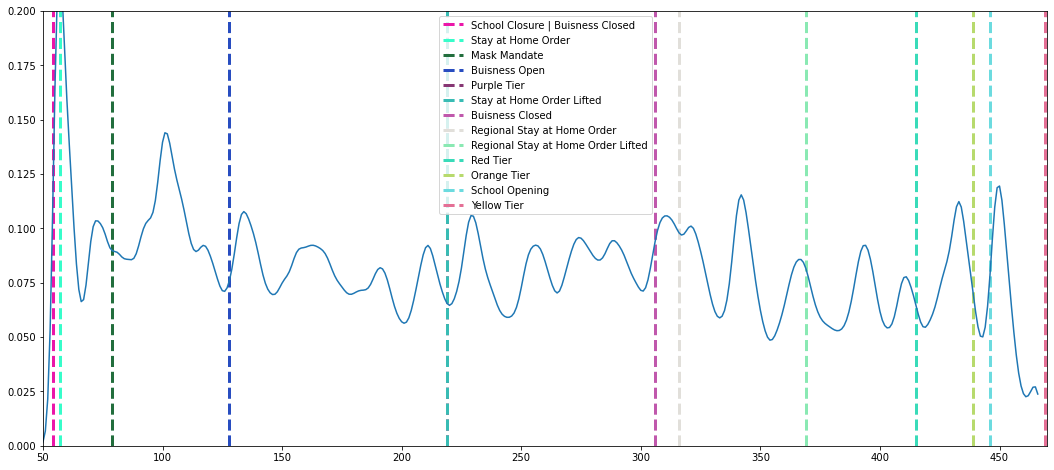

In [9]:
pathc="../Data/JHU Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
#Change state abbreviation based on the state you want to use
file = "LA County.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
fig,ax = plt.subplots(figsize = (18,8))
pop = 10040000
q = 1
window = 13
hWin = window // 2

beta = getBeta(pop, q, infectRaw, deadRaw, window)
beta = betaWithKernel(beta)
ax.plot(beta)

pathM = "../Data/State Closure Data/County Closure Data/"
fileM = "Los Angeles County, CA.csv"
csvfile=open(pathM+fileM, newline='', encoding='UTF-8')
rd = csv.reader(csvfile, delimiter=',')
data=[]
for lv in rd: #generating the data matrix
    data.append(lv)
aData=(data[1:])
mandates = []
mDates = []
lost = 0
for i in range (len(aData)):
    if '"' in aData[i][1]:
        continue
    elif 'Labor' in aData[i][1]:
        continue
    elif 'Thanksgiving' in aData[i][1]:
        continue
    elif 'Fourth' in aData[i][1]:
        continue
    elif 'Christmas' in aData[i][1]:
        continue
    elif 'New' in aData[i][1]:
        continue
    else:
        mandates.append(aData[i][1])
        mDates.append(getMandate(pathM+fileM, dates, mandates[len(mandates)-1], exact = True))

mDind = []
dates = dates.tolist()

for i in range (len(mDates)):
    if mDates[i][0] == '':
        continue
    if mDates[i][0] == '6/15/2021':
        continue
    mDind.append(dates.index(mDates[i][0]))

ax.set_ylim(0,0.2)
for i in range (len(mDind)):
    r = random.random()
    g = random.random()
    b = random.random()
    col = (r, g, b)
    plt.vlines(x=mDind[i], color = col, ymin=0, linestyle='dashed', ymax=0.2, label=mandates[i], linewidth=3)
ax.set_xlim(50,470)
ax.legend()

## Stay at Home Order's and Mask Mandate

<ipython-input-11-2631f4e825a3>:81: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-11-2631f4e825a3>:81: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]


Standard Deviation of Stay at Home County: 0.017123363615197694
Mean of Stay at Home County: 0.09233633918252808
Standard Deviation of Stay at Home State: 0.016260108191016545
Mean of Stay at Home State: 0.08091071647448148
Standard Deviation of Mask Mandate County: 0.014068054020485882
Mean of Mask Mandate County: 0.09119783427980421
Standard Deviation of Regional Stay at Home County: 0.008035740722162697
Mean of Regional Stay at Home County: 0.0807642968777099
BB for State Stay At Home 0.1033281646747077


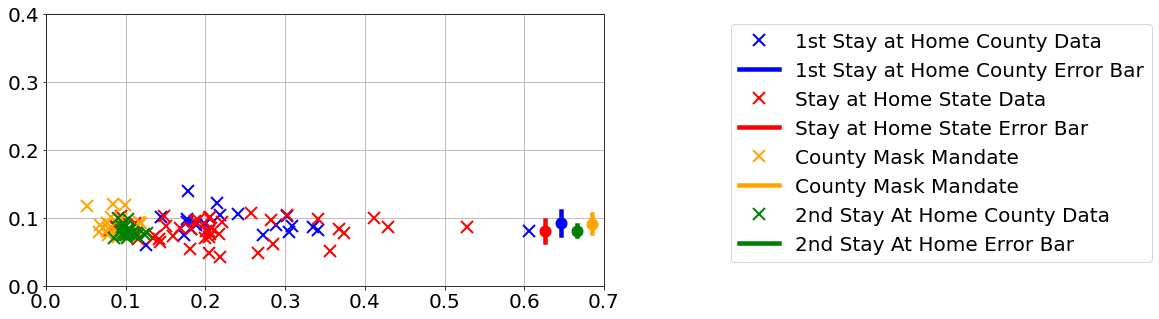

In [13]:
fig,ax = plt.subplots(figsize = (10,5))

#Getting and Plotting County Data
bBC, bAC = getBetaDistribution("Stay at Home Order", county = True, exact = True)
ax.plot(bBC,bAC, 'x', label = '1st Stay at Home County Data', color = 'blue', markersize = 12, markeredgewidth=2)
 
mean=np.mean(bAC)
std=np.std(bAC)
ys = (mean - std ) / (.4)
yb = (mean + std ) / (.4)


#Plotting the County Data Bar
plt.axvline(x=np.max(bBC)+0.04, ymin = ys, ymax = yb, label = '1st Stay at Home County Error Bar', color = 'blue', linewidth = 4.5)
ax.plot(np.max(bBC) +0.04, mean, 'bo', markersize = 11)

print("Standard Deviation of Stay at Home County:", np.std(bAC))
print("Mean of Stay at Home County:", np.mean(bAC))

#Getting and Plotting State Data
bBS, bAS =  getBetaDistribution("Stay at Home Order")
ax.plot(bBS,bAS, 'x', label = 'Stay at Home State Data', color = 'red', markersize = 12, markeredgewidth =2)

meanS = np.mean(bAS)
stdS = np.std(bAS)
ysS = (meanS - stdS ) / (.4)
ybS = (meanS + stdS ) / (.4)

#Plotting the State Data Bar
plt.axvline(x=np.max(bBC)+0.02, ymin = ysS, ymax = ybS, color = 'red', label = 'Stay at Home State Error Bar', linewidth=4.5)
ax.plot(np.max(bBC)+0.02, meanS, 'ro', markersize = 11)

print("Standard Deviation of Stay at Home State:", np.std(bAS))
print("Mean of Stay at Home State:", np.mean(bAS))


#Getting and Plotting Mask Mandate
bBM, bAM = getBetaDistribution("Mask Mandate", county = True ,exact = True)
ax.plot(bBM,bAM, 'x', label = 'County Mask Mandate', color = 'orange', markersize = 12, markeredgewidth = 2)

mean=np.mean(bAM)
std=np.std(bAM)
ys = (mean - std ) / (.4)
yb = (mean + std ) / (.4)

#Plotting Mask Mandate Bar
plt.axvline(x=np.max(bBC)+0.08, ymin = ys, ymax = yb, label = 'County Mask Mandate', color = 'orange', linewidth = 4.5)
ax.plot(np.max(bBC) +0.08, mean, 'o', color = 'orange', markersize = 11)

print("Standard Deviation of Mask Mandate County:", np.std(bAM))
print("Mean of Mask Mandate County:", np.mean(bAM))


#Getting and Plotting Regional County Data
bBR, bAR = getBetaDistribution("Regional Stay at Home Order", county = True ,exact = True)
ax.plot(bBR,bAR, 'x', label = '2nd Stay At Home County Data', color = 'green', markersize = 12, markeredgewidth = 2)

mean=np.mean(bAR)
std=np.std(bAR)
ys = (mean - std ) / (.4)
yb = (mean + std ) / (.4)

#Plotting the Regional County Bar
plt.axvline(x=np.max(bBC)+0.06, ymin = ys, ymax = yb, label = '2nd Stay At Home Error Bar', color = 'green', linewidth=4.5)
ax.plot(np.max(bBC) +0.06, mean, 'go', markersize = 11)

print("Standard Deviation of Regional Stay at Home County:", np.std(bAR))
print("Mean of Regional Stay at Home County:", np.mean(bAR))
print("BB for State Stay At Home", np.mean(bBR))


#Customizing the Figure
#ax.set_title("Stay at Home Order", fontsize = 30)
#ax.set_xlabel("Beta Before", fontsize = 20)
#ax.set_ylabel("Beta After", fontsize = 20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
ax.legend(fontsize = 20, bbox_to_anchor=(2, 1))
ax.grid()
#ax.set_xlim(0,np.max(bBC)+0.1)
#ax.set_ylim(0,np.max(bBC)+0.1)

ax.set_ylim(0,0.4)
ax.set_xlim(0,0.7)
#figsize=(hw,hw*(yrange/xrange)

plt.savefig("../Figures/Measures Comparing Counties and States.png", dpi=600, facecolor='w', edgecolor='w',orientation='portrait', format="png",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

## School Closure

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))

bBC, bAC = getBetaDistribution("School Closure", county = True)
ax.plot(bBC,bAC, 'x', label = 'County Data', color = 'blue')

mean = np.mean(bAC)
std = np.std(bAC)
ys = (mean - std ) / (np.max(bBC)+0.1)
yb = (mean + std ) / (np.max(bBC)+0.1)
#Plotting the State Data Bar
plt.axvline(x=np.max(bBC)+0.05, ymin = ys, ymax = yb, color = 'blue', label = 'County Error Bar')
ax.plot(np.max(bBC)+0.05, mean, 'bo', fillstyle = 'none')

bBS, bAS = getBetaDistribution("School Closure")
ax.plot(bBS,bAS, 'o', label = 'State Data', color = 'red')

meanS = np.mean(bAS)
stdS = np.std(bAS)
ys = (meanS - stdS ) / (np.max(bBC)+0.1)
yb = (meanS + stdS ) / (np.max(bBC)+0.1)
#Plotting the State Data Bar
plt.axvline(x=np.max(bBC)+0.06, ymin = ys, ymax = yb, color = 'red', label = 'State Error Bar')
ax.plot(np.max(bBC)+0.06, meanS, 'ro', fillstyle = 'none')



ax.set_title("School Closure", fontsize=30)
ax.set_xlabel("Beta Before")
ax.set_ylabel("Beta After")
ax.legend(fontsize = 20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

ax.set_xlim(0,np.max(bBC)+0.1)
ax.set_ylim(0,np.max(bBC)+0.1)



plt.savefig("../Figures/School Closure Comparing Counties and States.svg", dpi=200, facecolor='w', edgecolor='w',orientation='portrait', format="svg",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


## Business Closure

In [ ]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)

bB = [] #Store the Beta Before Values
bA = [] #Store the Beta After Values

for file in arr:
    pathc='../Data/JHU Data/County Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    if '.DS_Store' in file:
        continue
    #Change state abbreviation based on the state you want to use

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
    
    
    cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
    cName = convert[cState]
    cCounty = file[0:file.index(',')] #Get the county name

    #Change population based on the county you want to use
    pop = int(getPopC(cCounty,cState))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    #beta = betaWithKernel(beta)
    #fig, ax = plt.subplots(figsize= (18,8))
    #ax.plot(beta)
    temp = dates.tolist()
    pathc='../Data/State Closure Data/County Closure Data/'
    
    #Change function call of mM to change the policy
    mM = getBusinessClosed(pathc+file, dates)
    
    #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
    for k in range(len(mM)): 
        tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
        bB.append(tB)
        bA.append(tA)
        
#Get rid of weird invalid cases
i = 0
while i < len(bB):
    if bB[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bB[i]):
        del bB[i]
        del bA[i]
        i-= 1
    if np.isinf(bB[i]):
        del bB[i]
        del bA[i]
        i-=1
    i+=1
    
i = 0
while i < len(bA):
    if bA[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bA[i]):
        del bB[i]
        del bA[i]
        i-=1
    if np.isinf(bA[i]):
        del bB[i]
        del bA[i]  
        i-=1
    i+=1
#Plotting the beta before and after points
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o', label = 'County Data')


#Creating the line of best fit
bB = np.array(bB)
bB = bB[:,np.newaxis]
bestFit = np.linalg.lstsq(bB,bA, rcond = None)[0]
bA = np.array(bA)
f = ax.figure
f.set_figwidth(10)
f.set_figheight(10)

#Plotting Line of best fit
#x = np.linspace(0, bB.max(), 100)
#ax.plot(x,x*bestFit,color = "blue", linestyle = 'dashed', label = 'Line of Best Fit')

#Plotting line y=x
#ax.plot([0,0,bB.max()],[0,0,bB.max()])
#ax.axis([0,0.12,0,0.12])


print("Standard Deviation of County:", np.std(bA))
print("Mean of County:", np.mean(bA))
print("The expected average percentage change in beta is: ", (float(bestFit)-1) * 100, "%")


getBetaDistribution( "Business Closure", ax)

ax.set_title("Business Closure", fontsize=30)
ax.set_xlabel("Beta Before")
ax.set_ylabel("Beta After")
ax.legend(fontsize = 20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

ax.set_xlim(0,0.4)
ax.set_ylim(0,0.4)

plt.savefig("../Figures/Business Closure Comparing Counties and States", dpi=200, facecolor='w', edgecolor='w',orientation='portrait', format="svg",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


## Gathering Ban

In [ ]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)

bB = [] #Store the Beta Before Values
bA = [] #Store the Beta After Values

for file in arr:
    pathc='../Data/JHU Data/County Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    if '.DS_Store' in file:
        continue
    #Change state abbreviation based on the state you want to use

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
    
    
    cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
    cName = convert[cState]
    cCounty = file[0:file.index(',')] #Get the county name

    #Change population based on the county you want to use
    pop = int(getPopC(cCounty,cState))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    #beta = betaWithKernel(beta)
    #fig, ax = plt.subplots(figsize= (18,8))
    #ax.plot(beta)
    temp = dates.tolist()
    pathc='../Data/State Closure Data/County Closure Data/'
    
    #Change function call of mM to change the policy
    mM = getGatheringsDisallowed(pathc+file, dates)
    
    #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
    for k in range(len(mM)): 
        tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
        bB.append(tB)
        bA.append(tA)
        
#Get rid of weird invalid cases
i = 0
while i < len(bB):
    if bB[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bB[i]):
        del bB[i]
        del bA[i]
        i-= 1
    if np.isinf(bB[i]):
        del bB[i]
        del bA[i]
        i-=1
    i+=1
    
i = 0
while i < len(bA):
    if bA[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bA[i]):
        del bB[i]
        del bA[i]
        i-=1
    if np.isinf(bA[i]):
        del bB[i]
        del bA[i]  
        i-=1
    i+=1
#Plotting the beta before and after points
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o', label = 'County Data')

#Creating the line of best fit
bB = np.array(bB)
bB = bB[:,np.newaxis]
bestFit = np.linalg.lstsq(bB,bA, rcond = None)[0]
bA = np.array(bA)
f = ax.figure
f.set_figwidth(10)
f.set_figheight(10)

#Plotting Line of best fit
#x = np.linspace(0, bB.max(), 100)
#ax.plot(x,x*bestFit,color = "blue", linestyle = 'dashed', label = 'Line of Best Fit')

#Plotting line y=x
#ax.plot([0,0,bB.max()],[0,0,bB.max()])
#ax.axis([0,0.12,0,0.12])
ax.set_title("Gatherings")
ax.set_xlabel("Beta Before")
ax.set_ylabel("Beta After")
ax.legend(fontsize = 20)


print("Standard Deviation of County:", np.std(bA))
print("Mean of County:", np.mean(bA))
print("The expected average percentage change in beta is: ", (float(bestFit)-1) * 100, "%")


getBetaDistribution( "Gatherings Disallowed", ax)


